In [1]:
# Google Drive Connection
from google.colab import drive
drive.mount('/content/drive')

!ls '/content/drive/My Drive/fake-or-not/data/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
dataset.zip  ps_battles_ela_X.npy  ps_battles_ela_Y.npy  Untitled0.ipynb


In [0]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

# Image processing and ELA conversion
from PIL import Image
from pylab import *
import re
from PIL import Image, ImageChops, ImageEnhance

# General ML models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
# from pandas_ml import ConfusionMatrix

from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np

import keras
from keras.engine.input_layer import Input
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Add, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import cv2
from skimage import io
import tensorflow as tf

In [3]:
'''
Load data from numpy binaries
'''

X_path = '/content/drive/My Drive/fake-or-not/data/ps_battles_ela_X.npy'
X = np.load(X_path)
print('X shape:', X.shape)

Y_path = '/content/drive/My Drive/fake-or-not/data/ps_battles_ela_Y.npy'
Y = np.load(Y_path)
print('Y shape:', Y.shape)


X shape: (21182, 128, 128, 3)
Y shape: (21182, 2)


In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=4)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2, random_state=4)

In [0]:
# release GPU memory
tf.keras.backend.clear_session()

# resnet model
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

def resnet_v2(input_shape, depth, num_classes=2):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    
    # start model definition
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2     # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [12]:
input_shape = X.shape[1:]
n = 3
depth = n * 9 + 2
model = resnet_v2(input_shape=input_shape, depth=depth)
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr_schedule(0)),
              metrics=['accuracy'])

model.summary()

Learning rate:  0.001
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 16) 0           batch_normalization_1[0][0]      
______________________________________________________________________

In [0]:
model_type = 'ResNet{}'.format(depth)
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = '%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

In [21]:
n_samples = 100 #X.shape[0]
batch_size = 32
epochs = 15
history = model.fit(X_train[:n_samples], Y_train[:n_samples],
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(X_val, Y_val),
              shuffle=True,
              verbose=1,
              callbacks=callbacks)

Train on 100 samples, validate on 3389 samples
Epoch 1/15
Learning rate:  0.001
100/100 [==============================] - 11s 110ms/step - loss: 0.2141 - accuracy: 0.9500 - val_loss: 1.9097 - val_accuracy: 0.6503
Epoch 2/15
Learning rate:  0.001


/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


100/100 [==============================] - 11s 108ms/step - loss: 0.1638 - accuracy: 0.9800 - val_loss: 2.2988 - val_accuracy: 0.6022
Epoch 3/15
Learning rate:  0.001
100/100 [==============================] - 11s 108ms/step - loss: 0.3605 - accuracy: 0.9000 - val_loss: 3.0254 - val_accuracy: 0.6580
Epoch 4/15
Learning rate:  0.001
100/100 [==============================] - 11s 108ms/step - loss: 1.2820 - accuracy: 0.7900 - val_loss: 54.1974 - val_accuracy: 0.4987
Epoch 5/15
Learning rate:  0.001
100/100 [==============================] - 11s 108ms/step - loss: 0.4005 - accuracy: 0.9300 - val_loss: 132.1087 - val_accuracy: 0.4978
Epoch 6/15
Learning rate:  0.001
100/100 [==============================] - 11s 108ms/step - loss: 0.4419 - accuracy: 0.8600 - val_loss: 230.5329 - val_accuracy: 0.4999
Epoch 7/15
Learning rate:  0.001
100/100 [==============================] - 11s 108ms/step - loss: 0.2600 - accuracy: 0.9600 - val_loss: 275.6220 - val_accuracy: 0.5004
Epoch 8/15
Learning rate

In [24]:
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam

base_model=MobileNet(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(2,activation='softmax')(x) #final layer with softmax activation

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr_schedule(0)),
              metrics=['accuracy'])

model.summary()

n_samples = 500 #X.shape[0]
batch_size = 32
epochs = 15
history = model.fit(X_train[:n_samples], Y_train[:n_samples],
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(X_val, Y_val),
              shuffle=True,
              verbose=1,
              callbacks=callbacks)

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Learning rate:  0.001
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 16) 0           batch_normalization_1[0][0]      
______________________________________________________________________

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


500/500 [==============================] - 14s 29ms/step - loss: 0.4467 - accuracy: 0.8900 - val_loss: 7.5201 - val_accuracy: 0.5190
Epoch 3/15
Learning rate:  0.001
500/500 [==============================] - 14s 29ms/step - loss: 0.2999 - accuracy: 0.9540 - val_loss: 2.2027 - val_accuracy: 0.5916
Epoch 4/15
Learning rate:  0.001
500/500 [==============================] - 14s 29ms/step - loss: 0.2307 - accuracy: 0.9800 - val_loss: 1.5999 - val_accuracy: 0.6202
Epoch 5/15
Learning rate:  0.001
500/500 [==============================] - 14s 29ms/step - loss: 0.2371 - accuracy: 0.9780 - val_loss: 1.4273 - val_accuracy: 0.6477
Epoch 6/15
Learning rate:  0.001
500/500 [==============================] - 14s 29ms/step - loss: 0.1896 - accuracy: 0.9860 - val_loss: 1.3782 - val_accuracy: 0.6409
Epoch 7/15
Learning rate:  0.001
500/500 [==============================] - 14s 29ms/step - loss: 0.2030 - accuracy: 0.9860 - val_loss: 1.3919 - val_accuracy: 0.6497
Epoch 8/15
Learning rate:  0.001
500/

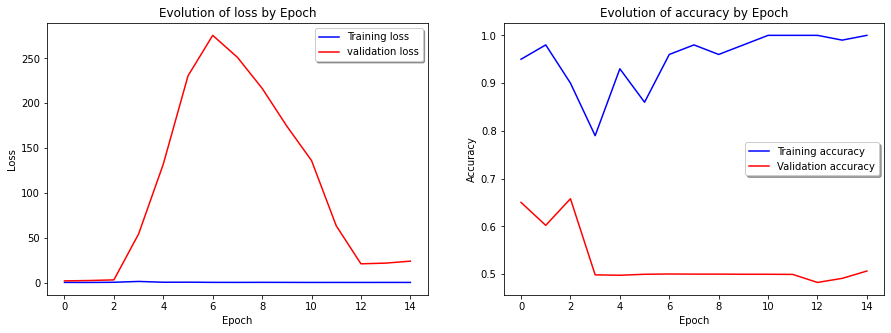

In [22]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
ax[0].set_ylabel("Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_title("Evolution of loss by Epoch")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax[1].set_ylabel("Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_title("Evolution of accuracy by Epoch")
legend = ax[1].legend(loc='best', shadow=True)

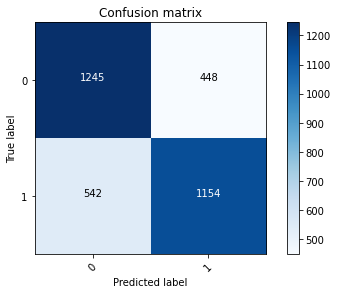

In [16]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))

# ~65% accuracy



In [0]:
# https://towardsdatascience.com/how-to-visualize-convolutional-features-in-40-lines-of-code-70b7d87b0030
class FilterVisualizer():
    def __init__(self, size=56, upscaling_steps=12, upscaling_factor=1.2):
        self.size, self.upscaling_steps, self.upscaling_factor = size, upscaling_steps, upscaling_factor
        self.model = vgg16(pre=True).cuda().eval()
        set_trainable(self.model, False)

    def visualize(self, layer, filter, lr=0.1, opt_steps=20, blur=None):
        sz = self.size
        img = np.uint8(np.random.uniform(150, 180, (sz, sz, 3)))/255  # generate random image
        activations = SaveFeatures(list(self.model.children())[layer])  # register hook

        for _ in range(self.upscaling_steps):  # scale the image up upscaling_steps times
            train_tfms, val_tfms = tfms_from_model(vgg16, sz)
            img_var = V(val_tfms(img)[None], requires_grad=True)  # convert image to Variable that requires grad
            optimizer = torch.optim.Adam([img_var], lr=lr, weight_decay=1e-6)
            for n in range(opt_steps):  # optimize pixel values for opt_steps times
                optimizer.zero_grad()
                self.model(img_var)
                loss = -activations.features[0, filter].mean()
                loss.backward()
                optimizer.step()
            img = val_tfms.denorm(img_var.data.cpu().numpy()[0].transpose(1,2,0))
            self.output = img
            sz = int(self.upscaling_factor * sz)  # calculate new image size
            img = cv2.resize(img, (sz, sz), interpolation = cv2.INTER_CUBIC)  # scale image up
            if blur is not None: img = cv2.blur(img,(blur,blur))  # blur image to reduce high frequency patterns
        self.save(layer, filter)
        activations.close()
        
    def save(self, layer, filter):
        plt.imsave("layer_"+str(layer)+"_filter_"+str(filter)+".jpg", np.clip(self.output, 0, 1))


layer = 40
filter = 265
FV = FilterVisualizer(size=56, upscaling_steps=12, upscaling_factor=1.2)
FV.visualize(layer, filter, blur=5)
